<a href="https://colab.research.google.com/github/Higgins2718/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

train['dangerous'] = train['Risk'].str.contains('High')
test['dangerous'] = test['Risk'].str.contains('High')
train['not_dangerous'] = train['Risk'].str.contains('Low')
test['not_dangerous'] = test['Risk'].str.contains('Low')
train['complaint'] = train['Inspection Type'].str.contains('Complaint')
test['complaint'] = test['Inspection Type'].str.contains('Complaint')
train['canvas'] = train['Inspection Type'].str.contains('Canvas')
test['canvas'] = test['Inspection Type'].str.contains('Canvas')
train['restaurant'] = train['Facility Type'].str.contains('Restaurant')
test['restaurant'] = test['Facility Type'].str.contains('Restaurant')

###Part 1: Preprocessing
You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

In [2]:
train.head(500)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail,dangerous,not_dangerous,complaint,canvas,restaurant
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,True,False,False,True,True
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,False,True,True,False,False
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,True,False,False,True,True
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,False,False,False,True,True
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,True,False,False,True,False
5,1725221,LAKEVIEW REHABILITATION AND NURSING CENTER,LAKEVIEW REHABILITATION AND NURSING CENTER,2245580.0,Long Term Care,Risk 1 (High),735 W DIVERSEY PKWY,CHICAGO,IL,60614.0,2016-02-22T00:00:00,Canvass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.932632,-87.647973,"{'longitude': '-87.64797278441709', 'latitude'...",0,True,False,False,True,False
6,1981372,GOLD COAST DOGS,GOLD COAST DOGS,32318.0,Restaurant,Risk 2 (Medium),225 S CANAL ST,CHICAGO,IL,60606.0,2017-01-12T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.878531,-87.639427,"{'longitude': '-87.63942745962717', 'latitude'...",0,False,False,False,True,True
7,1072403,HAPPY PIZZA,NaN,2241028.0,Restaurant,Risk 1 (High),8710 S HALSTED ST,CHICAGO,IL,60620.0,2013-05-07T00:00:00,License Re-Inspection,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.735505,-87.643749,"{'longitude': '-87.64374906595162', 'latitude'...",0,True,False,False,False,True
8,1464616,THE PUMPING CO INC,THE PUMPING CO,1544937.0,Restaurant,Risk 1 (High),6157 N BROADWAY,CHICAGO,IL,60660.0,2014-11-28T00:00:00,Canvass,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.993973,-87.660242,"{'longitude': '-87.66024237516903', 'latitude'...",1,True,False,False,True,True
9,583261,YUMMY YUMMY NOODLES,YUMMY YUMMY NOODLES,2098003.0,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616.0,2011-06-01T00:00:00,License,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.855282,-87.631993,"{'longitude': '-87.63199264229414', 'latitude'...",1,True,False,False,False,True


In [3]:
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail,dangerous,not_dangerous,complaint,canvas,restaurant
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0,False,False,False,True,False
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0,True,False,False,True,True
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0,True,False,False,True,True
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1,True,False,False,True,True
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1,False,False,False,True,False


In [0]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
#test["inspection_type__risk"] = test[(test['Inspection Type'] == 'Complaint Re-Inspection') & (test['Risk'] == 'Risk 1 (High)')]

train = train.drop(columns='Violations')
test = test.drop(columns='Violations')

X_train = train.drop(columns='Fail')
y_train = train.Fail

X_test = test.drop(columns='Fail')
y_test = test.Fail


lb_make = LabelEncoder()

X_train = X_train.drop(columns=['Address', 'Inspection Date', 'Location', 'Latitude', 'Longitude'])
X_test = X_test.drop(columns=['Address', 'Inspection Date', 'Location', 'Latitude', 'Longitude'])


X_train["DBA Name"] = lb_make.fit_transform(X_train["DBA Name"].astype(str))
X_train["AKA Name"] = lb_make.fit_transform(X_train["AKA Name"].astype(str))
X_train["Facility Type"] = lb_make.fit_transform(X_train["Facility Type"].astype(str))
X_train["Risk"] = lb_make.fit_transform(X_train["Risk"].astype(str))
X_train["Inspection Type"] = lb_make.fit_transform(X_train["Inspection Type"].astype(str))
X_train["City"] = lb_make.fit_transform(X_train["City"].astype(str))
X_train["State"] = lb_make.fit_transform(X_train["State"].astype(str))
X_train["dangerous"].fillna(method='ffill', inplace=True)
X_train["dangerous"] = lb_make.fit_transform(X_train["dangerous"].astype(int))
X_train["complaint"].fillna(method='ffill', inplace=True)
X_train["complaint"] = lb_make.fit_transform(X_train["complaint"].astype(int))

# Leakage
#X_train["Violations"] = lb_make.fit_transform(X_train["Violations"].astype(str))

X_test["DBA Name"] = lb_make.fit_transform(X_test["DBA Name"].astype(str))
X_test["AKA Name"] = lb_make.fit_transform(X_test["AKA Name"].astype(str))
X_test["Facility Type"] = lb_make.fit_transform(X_test["Facility Type"].astype(str))
X_test["Risk"] = lb_make.fit_transform(X_test["Risk"].astype(str))
X_test["Inspection Type"] = lb_make.fit_transform(X_test["Inspection Type"].astype(str))
X_test["City"] = lb_make.fit_transform(X_test["City"].astype(str))
X_test["State"] = lb_make.fit_transform(X_test["State"].astype(str))
X_test["dangerous"].fillna(method='ffill', inplace=True)

X_test["dangerous"] = lb_make.fit_transform(X_test["dangerous"].astype(int))
X_test["complaint"].fillna(method='ffill', inplace=True)
X_test["complaint"] = lb_make.fit_transform(X_test["complaint"].astype(int))
# Leakage
#X_test["Violations"] = lb_make.fit_transform(X_test["Violations"].astype(str))

# Very few null values, so I will simply drop the rows containing them
X_train = X_train.fillna(method='ffill')
X_test = X_test.fillna(method='ffill')

In [5]:
X_train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,City,State,Zip,Inspection Type,dangerous,not_dangerous,complaint,canvas,restaurant
0,2088270,15716,15088,2354911.0,246,0,10,0,60657.0,5,1,False,0,True,True
1,555268,5363,5109,1044901.0,147,2,10,0,60636.0,8,0,True,1,False,False
2,1751394,379,288,47405.0,246,0,10,0,60649.0,6,1,False,0,True,True
3,1763905,5595,5350,6414.0,246,1,10,0,60632.0,5,0,False,0,True,True
4,453326,10274,9864,24571.0,259,0,10,0,60629.0,5,1,False,0,True,False


In [6]:
y_test.head()

0    0
1    0
2    0
3    1
4    1
Name: Fail, dtype: int64

### We get leakage in a machine learning model when data from *outside* the training data is used *to constitute some part of the training data*. We see that in this training data with the "Violations" feature. These are (routine?) safety inspections. You can't know the violation before the inspection!

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LogisticRegression(solver='lbfgs'), X_train, y_train, 
                        scoring='roc_auc', cv=3, 
                        return_train_score=True, return_estimator=True)

In [8]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.347148,0.030275,"LogisticRegression(C=1.0, class_weight=None, d...",0.543929,0.535659
1,0.441435,0.028996,"LogisticRegression(C=1.0, class_weight=None, d...",0.523163,0.538559
2,0.263931,0.028938,"LogisticRegression(C=1.0, class_weight=None, d...",0.536856,0.533312


In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression



pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

In [0]:
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipeline, X_test, y_test, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:,1]

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc_score(y_test, y_pred_proba)

0.595186988216823

In [32]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.tree import DecisionTreeClassifier

param_distributions = {
    'max_depth': randint(1, 15)
}

search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(max_leaf_nodes=None,max_features=15, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='roc_auc', 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_depth=7 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ max_depth=7, score=0.6859720361891983, total=   0.2s
[CV] max_depth=7 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............ max_depth=7, score=0.6946003648919911, total=   0.2s
[CV] max_depth=7 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ............ max_depth=7, score=0.6964007890027302, total=   0.2s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] ............ max_depth=4, score=0.6668498903304853, total=   0.2s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ............ max_depth=4, score=0.6520802326948449, total=   0.2s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[CV] ............ max_depth=4, score=0.6595049312670636, total=   0.2s
[CV] max_depth=13 ....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


[CV] ........... max_depth=13, score=0.6635812233531636, total=   0.3s
[CV] max_depth=13 ....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s


[CV] ............ max_depth=13, score=0.663724632821991, total=   0.4s
[CV] max_depth=13 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


[CV] ........... max_depth=13, score=0.6637339771920734, total=   0.4s
[CV] max_depth=11 ....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


[CV] ........... max_depth=11, score=0.6749106606151664, total=   0.3s
[CV] max_depth=11 ....................................................
[CV] ........... max_depth=11, score=0.6793055469678695, total=   0.3s
[CV] max_depth=11 ....................................................
[CV] ............ max_depth=11, score=0.681185419995907, total=   0.3s
[CV] max_depth=8 .....................................................
[CV] ............ max_depth=8, score=0.6891804963790602, total=   0.3s
[CV] max_depth=8 .....................................................
[CV] ............ max_depth=8, score=0.6911035587854932, total=   0.3s
[CV] max_depth=8 .....................................................
[CV] ............ max_depth=8, score=0.6957073200468524, total=   0.3s
[CV] max_depth=13 ....................................................
[CV] ........... max_depth=13, score=0.6635812233531636, total=   0.4s
[CV] max_depth=13 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   45.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8414a8588>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [33]:
search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

## Roc_Auc nearly 70

In [34]:
search.best_score_

0.6923242743362049

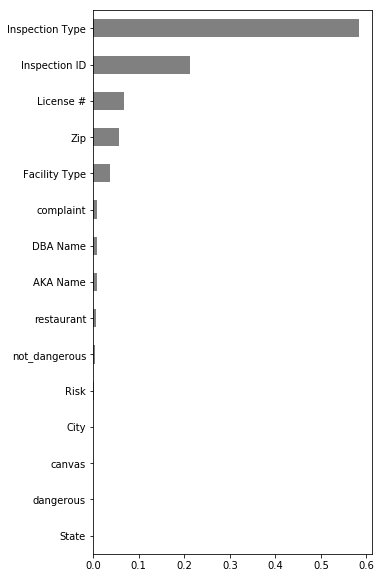

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='gray');

# Wow, finally.

# A partial dependence plot:

In [17]:
!pip install pdpbox

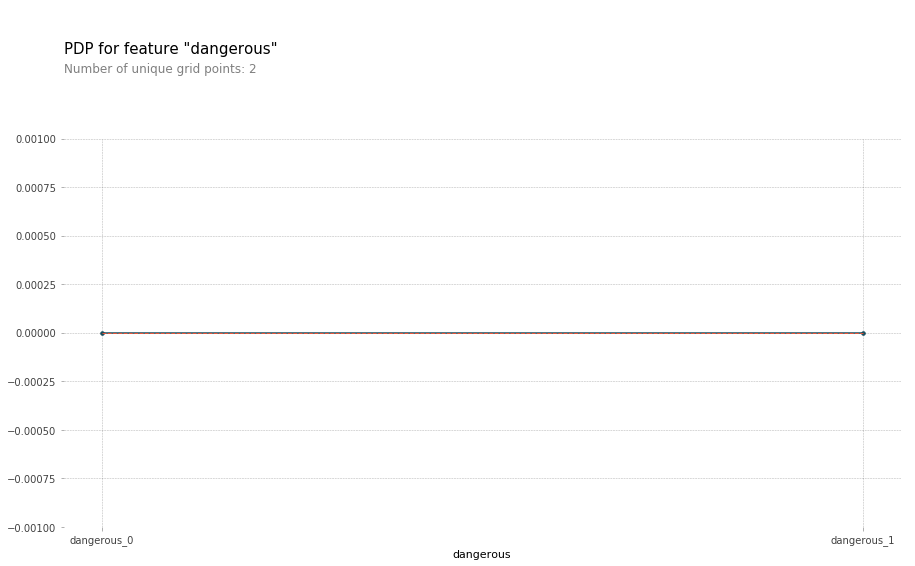

In [18]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'dangerous'

isolated = pdp_isolate(
    model=final, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

# Why do these give errors? Makes no sense to me. 

In [0]:
#X_train["inspection_type__risk"] = X_train[(X_train['Inspection Type'] == 8) & (X_train['Risk'] == 0)]
#X_train["inspection_type__risk"] = X_train[(X_train['Inspection Type'] == 8)]
#train["inspection_type_high_risk"] = train.loc[train['Inspection Type'] != 36]
#X_train['new_val'] = X_train.loc[X_train['Inspection Type'] != 36]


# Part 4 — Gradient Descent Explanation

Gradient descent seeks to minimize the cost function (AKA "loss function"). Typically, the cost function is equivalent to the mean squared error, though other cost functions are popularly used for different models.

In gradient descent, the learning rate can be thought of as the "size" of the "steps" down the imaginary mountain or hill. Mathematically, this is the size of the α value. If you were to take too high a step, you would risk "overshooting" your local minimum (or even your global minimum, if your luck was particularly bad). For this reason, it's often wise to start out with a relatively conservative learning rate.










### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._